In [4]:
import pyreadstat

# 读取 SAS 文件
df, meta = pyreadstat.read_sas7bdat("C:/Users/Bobli/bootcamp_Calvin_Li/project/data/stock_20250403.sas7bdat")

In [5]:
df.describe()
df.isna().sum()

code                    0
date                    0
trd_vol_shr        299102
trd_vol_rmb        298840
turnover           299129
year             10256637
week             10256637
price_close           384
mkt_val_total        8395
price_low            8219
price_high           8219
pe               10256637
ret                 10591
price_unadj        776497
price_open        8841872
price_close_l     8835136
dtype: int64

In [6]:
df = df[['code', 'date','turnover','price_close','mkt_val_total','pe','ret']]

In [7]:
df.describe()
df.isna().sum()

code                    0
date                    0
turnover           299129
price_close           384
mkt_val_total        8395
pe               10256637
ret                 10591
dtype: int64

In [8]:
df.dropna(subset=['turnover','price_close','mkt_val_total','pe','ret'], inplace=True)

The reason why I use dropna()function to deal with the NA is that it is hard to replace NA with a certain number like median or average because the stocks' prices varies dratically and very often. It is wrong to assume the stocks' price will follow a certain pattern. Therefore, I drop all the NA. The assumption behind this method is that the missing data is completely at random and is not important.

In [9]:
df.describe()

,turnover,price_close,mkt_val_total,pe,ret
count,5.084871e+06,5.084871e+06,5.084871e+06,5.084871e+06,5.084871e+06
mean,2.434063e+00,1.248455e+02,1.023916e+10,8.922088e+01,6.043633e-02
std,3.279661e+00,1.546926e+03,6.882776e+10,4.808994e+02,3.491489e+00
min,1.000000e-04,1.100300e+00,8.910000e+07,-4.333129e+04,-6.873330e+01
25%,6.066000e-01,1.308380e+01,1.704300e+09,2.171600e+01,-1.476800e+00
50%,1.358800e+00,2.286660e+01,2.947200e+09,3.970860e+01,3.930000e-02
75%,2.965300e+00,4.288200e+01,5.794912e+09,7.569540e+01,1.538500e+00
max,8.192270e+01,8.045531e+04,7.400000e+12,3.036408e+04,2.068421e+03


In [10]:
df.isna().sum()

code             0
date             0
turnover         0
price_close      0
mkt_val_total    0
pe               0
ret              0
dtype: int64

In [11]:
from src.outliers import detect_outliers_zscore

In [12]:
cols=['turnover','price_close','mkt_val_total','pe']

for col in cols:
    df[f'outlier_{col}'] = detect_outliers_zscore(df[col], threshold=3.0)


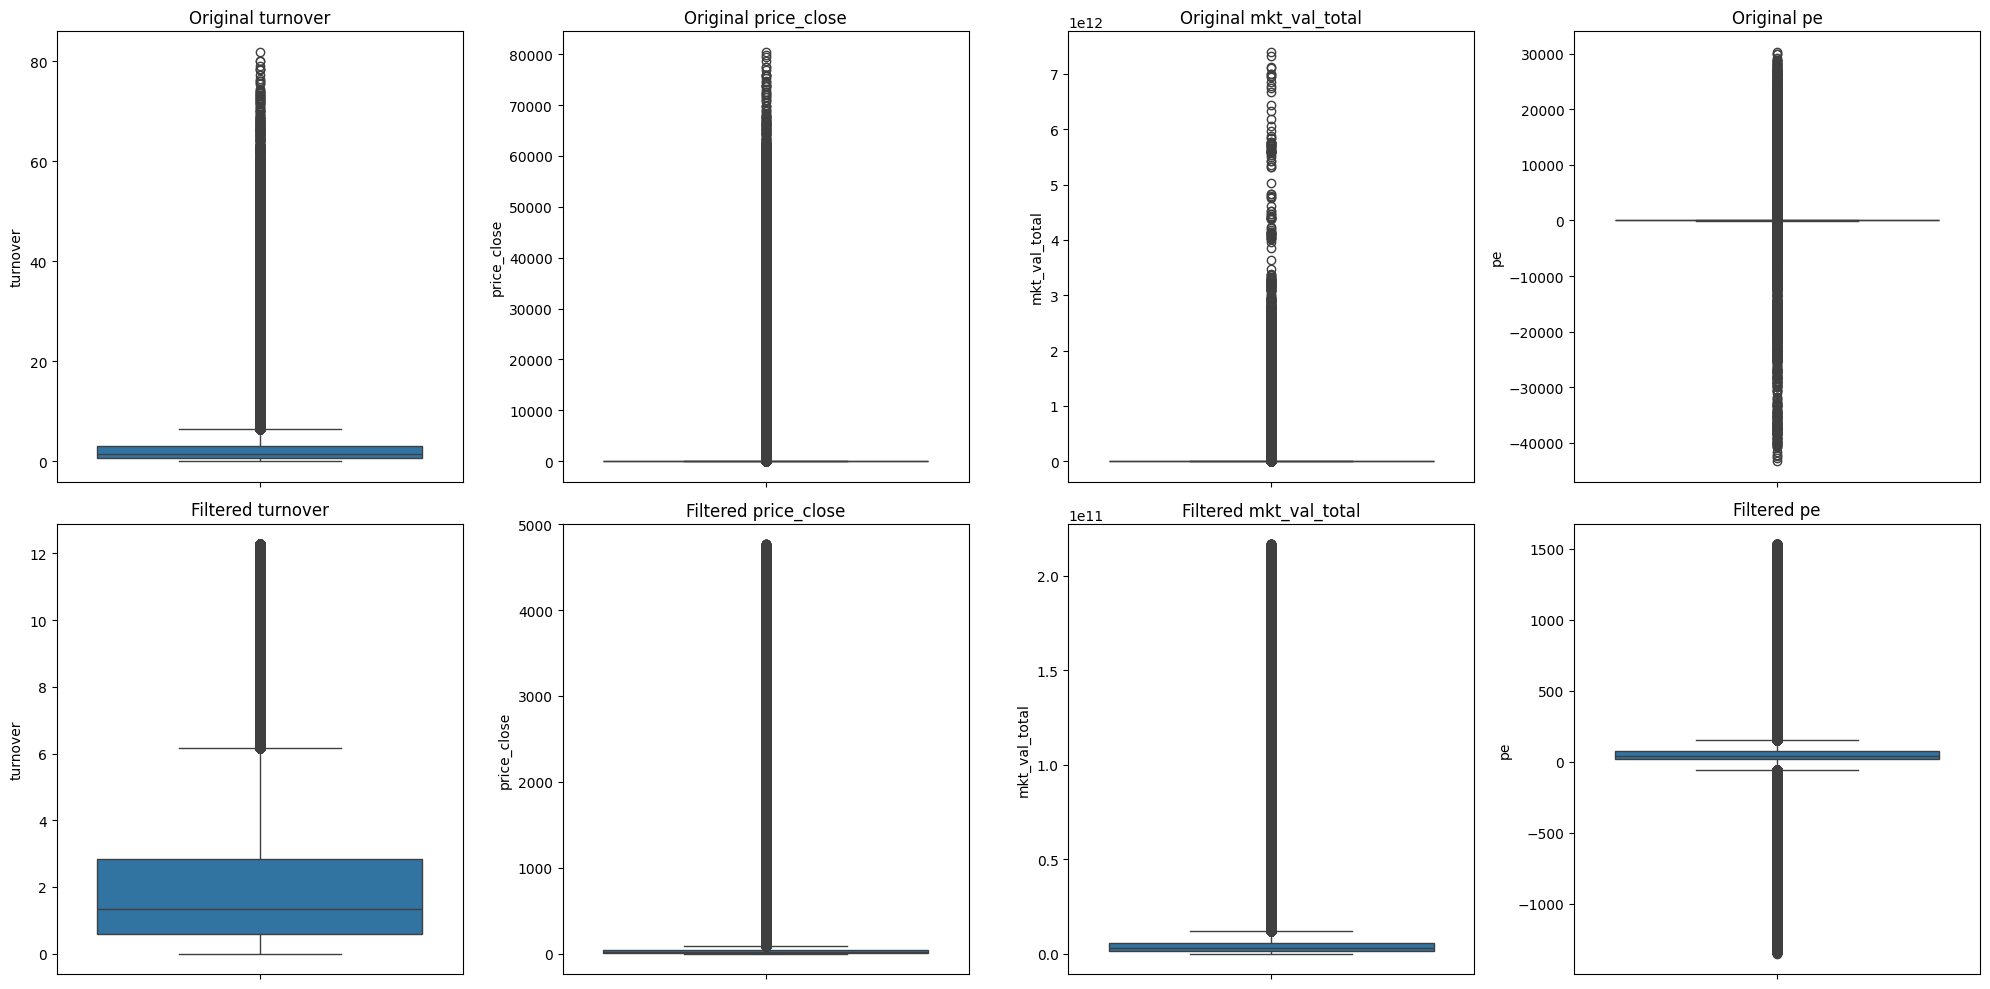

In [13]:
# 找出所有 outlier 列
outlier_cols = ['outlier_turnover','outlier_price_close','outlier_mkt_val_total','outlier_pe']

# 整行都不是异常值
mask = ~(df[outlier_cols].any(axis=1))   # any() 表示行中只要有一个 True，就算异常

# 过滤后的 DataFrame
df_filtered = df[mask]

import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(2, len(cols), figsize=(5*len(cols), 10))

for i, col in enumerate(cols):
    sns.boxplot(y=df[col], ax=axes[0, i])
    axes[0, i].set_title(f"Original {col}")

    sns.boxplot(y=df_filtered[col], ax=axes[1, i])
    axes[1, i].set_title(f"Filtered {col}")

plt.tight_layout()
plt.show()


In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd
X_all = df[['turnover','price_close','mkt_val_total','pe']].to_numpy(); y_all = df['ret'].to_numpy()
X_filtered = df_filtered[['turnover','price_close','mkt_val_total','pe']].to_numpy(); y_filtered = df_filtered['ret'].to_numpy()
model_all = LinearRegression().fit(X_all, y_all)
model_flt = LinearRegression().fit(X_filtered, y_filtered)

mae_all = mean_absolute_error(y_all, model_all.predict(X_all))
mae_flt = mean_absolute_error(y_filtered, model_flt.predict(X_filtered))

results = pd.DataFrame({
        'intercept': [model_all.intercept_, model_flt.intercept_],
        'r2': [model_all.score(X_all, y_all), model_flt.score(X_filtered, y_filtered)],
        'mae': [mae_all, mae_flt],
        'turnover_coef': [model_all.coef_[0], model_flt.coef_[0]],
        'price_close_coef': [model_all.coef_[1], model_flt.coef_[1]],
        'mkt_val_total_coef': [model_all.coef_[2], model_flt.coef_[2]],
        'pe_coef': [model_all.coef_[3], model_flt.coef_[3]]
    }, index=['all', 'filtered_iqr'])

print(results)

              intercept        r2       mae  turnover_coef  price_close_coef  \
all            0.057904  0.000013  2.116169   1.428486e-09          0.000002   
filtered_iqr  -0.011030  0.000089  2.062480   3.451844e-08          0.000102   

              mkt_val_total_coef   pe_coef  
all                 6.257124e-15  0.000025  
filtered_iqr        1.129513e-12  0.000103  


In [15]:
from scipy.stats import skew, kurtosis
desc =  df_filtered[['turnover','price_close','mkt_val_total','pe']].describe().T
desc['skew'] = [skew(df[c].dropna()) for c in desc.index]
desc['kurtosis'] = [kurtosis(df[c].dropna()) for c in desc.index]
desc

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
turnover,4915394.0,2.126905e+00,2.220962e+00,1.000000e-04,5.989000e-01,1.324900e+00,2.824300e+00,1.227300e+01,4.453311,36.619039
price_close,4915394.0,4.989832e+01,1.575693e+02,1.100300e+00,1.301000e+01,2.271090e+01,4.261540e+01,4.764697e+03,23.699847,638.441921
mkt_val_total,4915394.0,6.772396e+09,1.490244e+10,8.910000e+07,1.693500e+09,2.930325e+09,5.754097e+09,2.167184e+11,27.996934,1256.424313
pe,4915394.0,7.668512e+01,1.564254e+02,-1.353303e+03,2.160720e+01,3.930700e+01,7.429845e+01,1.531876e+03,-6.921019,1711.254536


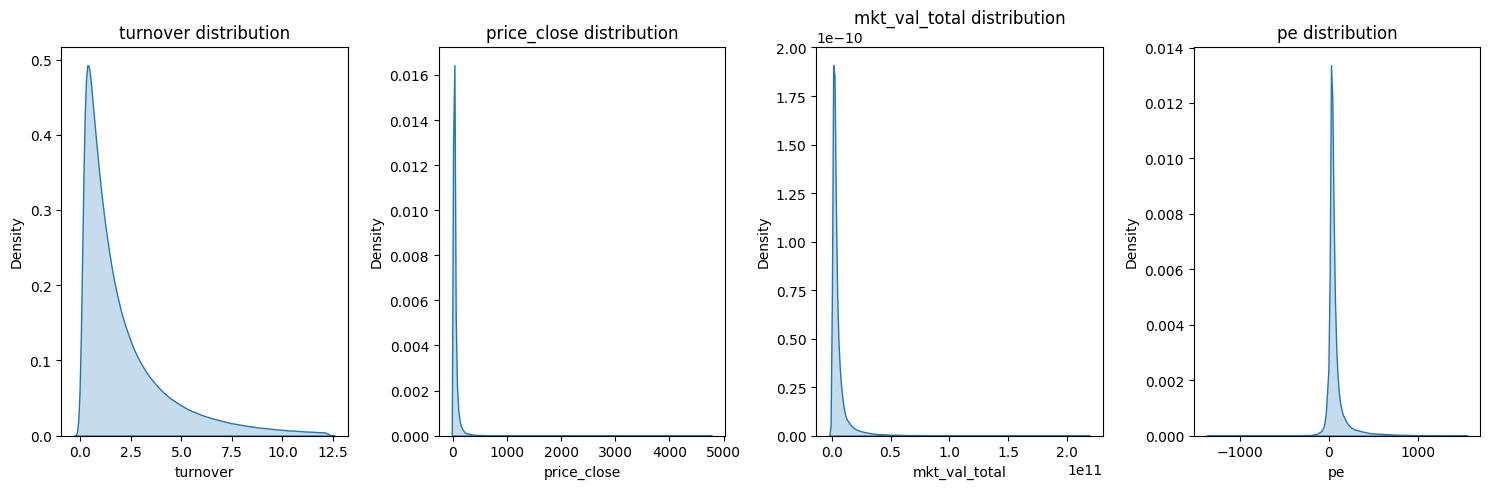

In [16]:
fig, axes = plt.subplots(1, len(cols), figsize=(15, 5))  # 一行多列子图

for i, col in enumerate(cols):
    sns.kdeplot(df_filtered[col], ax=axes[i], fill=True)  # 只画分布曲线
    axes[i].set_title(f"{col} distribution")

plt.tight_layout()
plt.show()

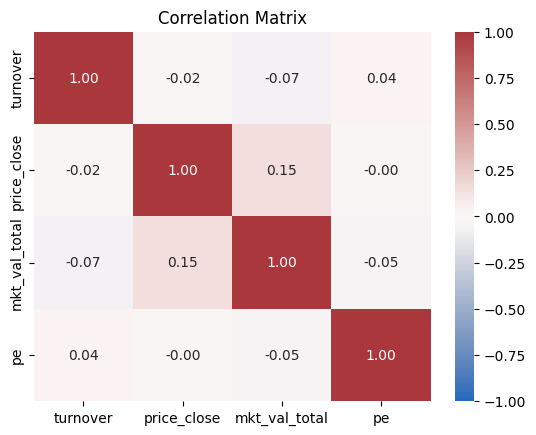

,turnover,price_close,mkt_val_total,pe
turnover,1.000000,-0.017737,-0.065175,0.035282
price_close,-0.017737,1.000000,0.146440,-0.004681
mkt_val_total,-0.065175,0.146440,1.000000,-0.053098
pe,0.035282,-0.004681,-0.053098,1.000000


In [17]:
corr = df_filtered[['turnover','price_close','mkt_val_total','pe']].corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt='.2f', cmap='vlag', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()
corr

In [18]:
##engineering features
#rolling mean
df_filtered = df_filtered.sort_values(['code', 'date'])
df_filtered['lag_ret'] = df_filtered.groupby('code')['ret'].shift(1)
df_filtered['roll_mean_5'] = (
    df_filtered.groupby('code')['ret']   
    .rolling(5)                              
    .mean()                                  
    .shift(1)                                
    .reset_index(level=0, drop=True)         
)
print(df_filtered)

               code        date  turnover  price_close  mkt_val_total  \
0         000001.SZ  2001-01-02    0.2449     329.5037   2.831171e+10   
1         000001.SZ  2001-01-03    0.3897     327.0126   2.809767e+10   
2         000001.SZ  2001-01-04    0.3475     324.9744   2.792255e+10   
3         000001.SZ  2001-01-05    0.4768     321.5774   2.763067e+10   
4         000001.SZ  2001-01-08    0.5021     317.0482   2.724151e+10   
...             ...         ...       ...          ...            ...   
14578000  603993.SH  2014-07-10    0.4168       6.9120   3.335044e+10   
14578001  603993.SH  2014-07-11    0.4761       6.9646   3.360425e+10   
14578002  603993.SH  2014-07-14    0.5857       7.1540   3.451796e+10   
14578003  603993.SH  2014-07-15    0.4115       7.0593   3.406110e+10   
14578004  603993.SH  2014-07-16    0.7137       7.2066   3.477177e+10   

               pe     ret  outlier_turnover  outlier_price_close  \
0         55.8911  0.2066             False            

In [21]:
##Linear Regression
df_filtered = df_filtered.sort_values([ 'date'])
cut=int(len(df_filtered)*0.8)
train, test = df_filtered.iloc[:cut].dropna(), df_filtered.iloc[cut:].dropna()
features=['turnover','price_close','mkt_val_total','pe','lag_ret','roll_mean_5']
X_tr, X_te = train[features], test[features]
y_tr, y_te = train['ret'], test['ret']

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import StandardScaler
reg = Pipeline([('scaler', StandardScaler()), ('linreg', LinearRegression())])
reg.fit(X_tr, y_tr)
y_pred = reg.predict(X_te)
mse = mean_squared_error(y_te, y_pred)
rmse = np.sqrt(mse)
print('RMSE:', rmse)
linreg_model = reg.named_steps['linreg']
results = pd.DataFrame({
        'intercept': [linreg_model.intercept_],
        'r2' :[reg.score(X_te, y_te)],
        
        'turnover_coef': [linreg_model.coef_[0]],
        'price_close_coef': [linreg_model.coef_[1]],
        'mkt_val_total_coef': [linreg_model.coef_[2]],
        'pe_coef': [linreg_model.coef_[3]],
        'lag_ret_coef':[linreg_model.coef_[4]],
        'roll_mean_5_coef':[linreg_model.coef_[5]]
    })

print(results)

RMSE: 2.5587067224330977
   intercept        r2  turnover_coef  price_close_coef  mkt_val_total_coef  \
0  -0.003764  0.013051        0.43693          0.019591            0.040497   

    pe_coef  lag_ret_coef  roll_mean_5_coef  
0  0.003559      0.112649         -0.133544  


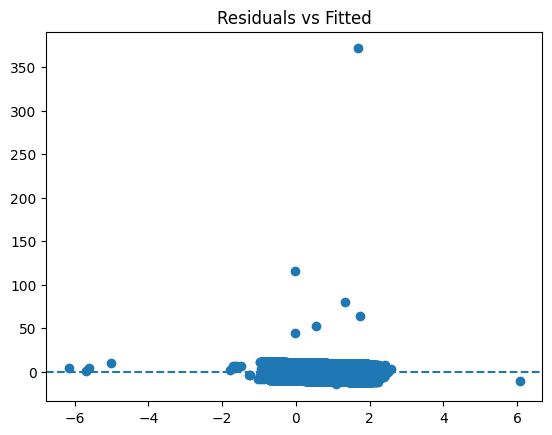

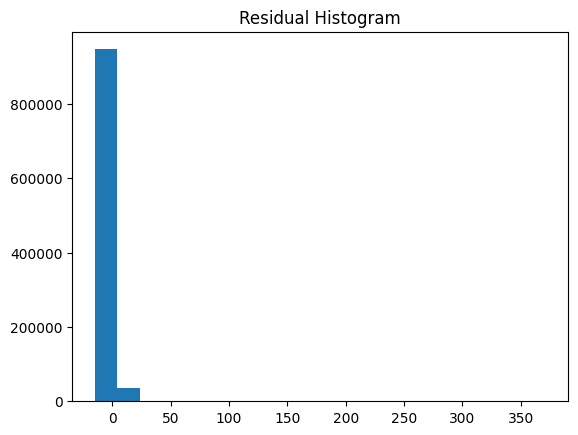

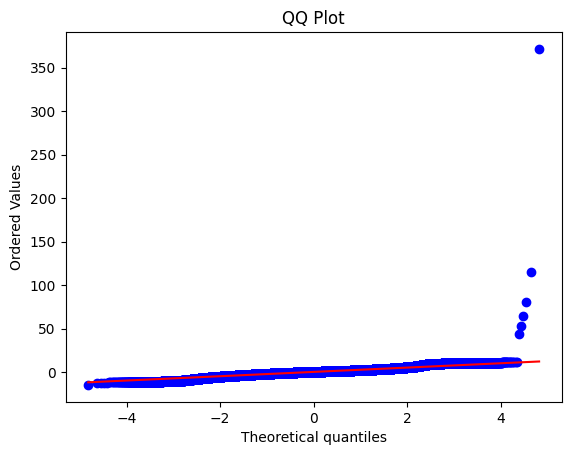

In [22]:
import scipy.stats as st
resid = y_te - y_pred
fitted = y_pred
plt.figure(); plt.scatter(fitted, resid); plt.axhline(0, ls='--'); plt.title('Residuals vs Fitted'); plt.show()
plt.figure(); plt.hist(resid, bins=20); plt.title('Residual Histogram'); plt.show()
plt.figure(); st.probplot(resid, dist='norm', plot=plt); plt.title('QQ Plot'); plt.show()